**Beginning Thought Process for Solution /  Pseudocode:**
 
Below is a great illustration of all the concepts (hfov, vfov, focal length, etc.) in this problem from [Long-Range Wireless Tethering Selfie Camera System Using Wireless Sensor Networks](https://www.researchgate.net/figure/Illustration-of-camera-lenss-field-of-view-FOV_fig4_335011596). From here, I have derived the formulas needed to get the offsets, yaw, and pitch. I could get the distance from this [formula](https://photo.stackexchange.com/questions/12434/how-do-i-calculate-the-distance-of-an-object-in-a-photo/12437#12437) that Craig suggested to me.

- `distance = (focalLength*objRealHeight*imgDimY) / (objImgHeight*sensorSize)`

- `relativeYoffset = (centerX/imgDimX * hfov) - (hfov / 2)`

- `relativeZOffset = objcenterY - (hfov_width / 2)`

- `yaw = inverse tangent of (objCenterX - imgCenterX) / distance`


- `pitch = inverse tangent of (imgCenterY - objCenterY) / distance`

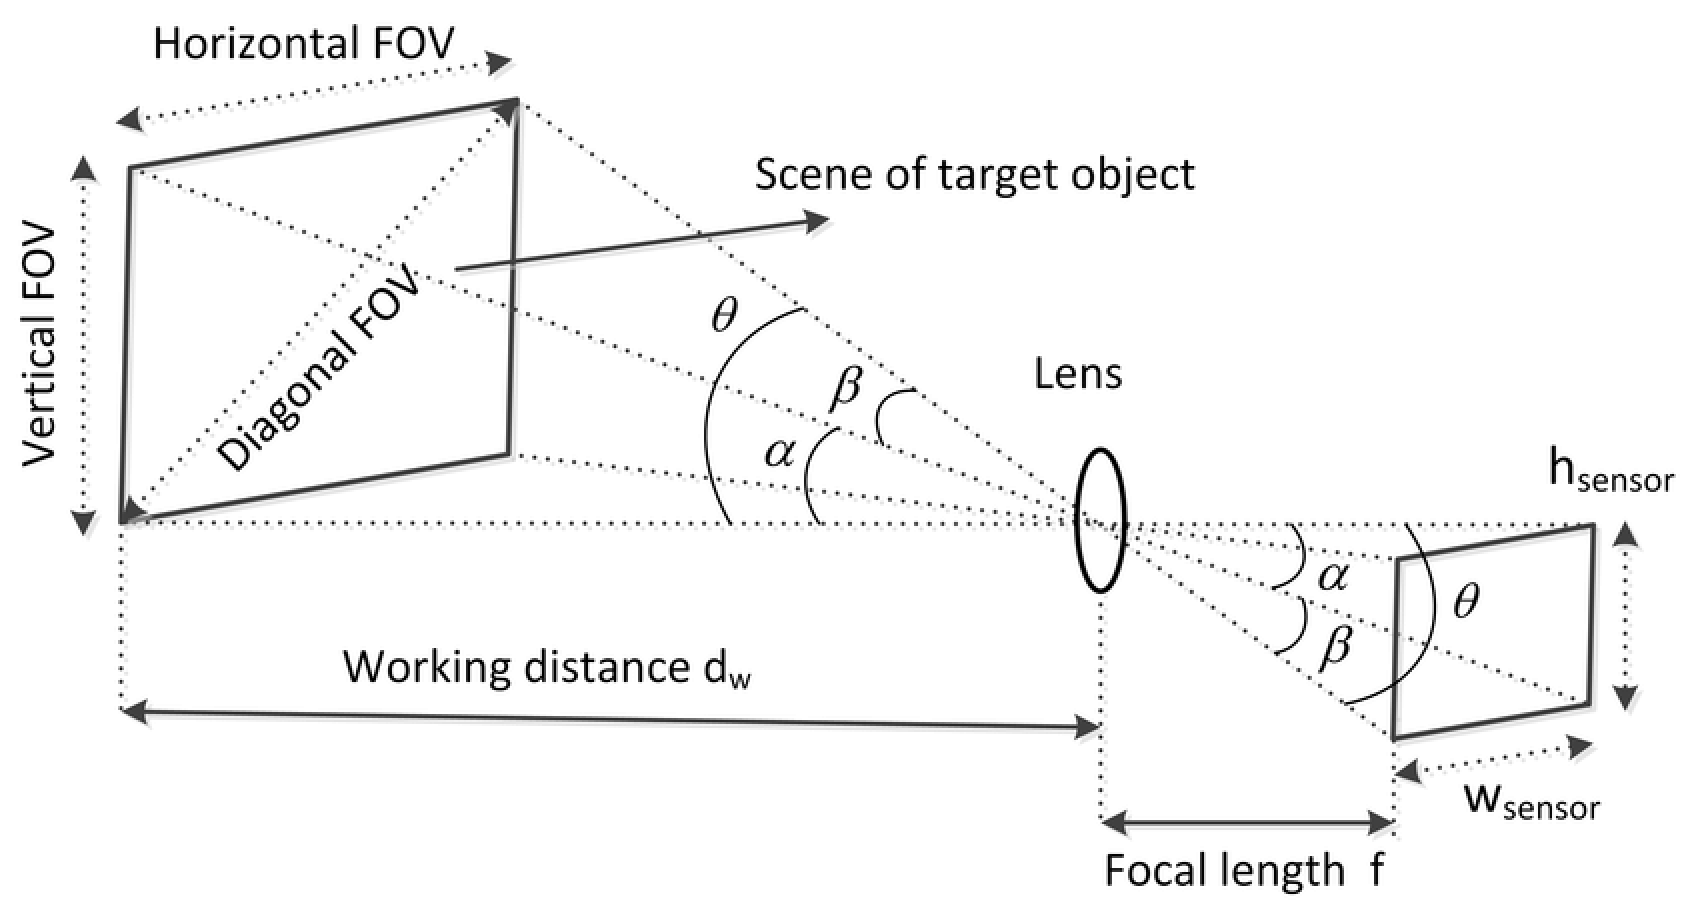

In [2]:
from IPython.display import Image
Image(filename="FOV_model.png")

In [6]:
import math
import sys

def pixel_to_meter(p: float, scale: float) -> float:
    return (p * scale) / 1000 # pixels to mm to meters

def calc_dist(focalLength, objRealHeight, imgDimY: float, objImgHeight, sensorSize) -> float:
    ''' Distance Formula '''

    d = (focalLength*objRealHeight*imgDimY) / (objImgHeight*sensorSize)
    d = d/1000

    return d

def angle_of_points(p1: list, p2: list, dist: float) -> tuple:
    ''' inverse of dist between 2 points over dist to object, for yaw and pitch '''

    yaw_r = math.atan((p1[0] - p2[0]) / dist)
    yaw_d = math.degrees(yaw_r)

    pitch_r = math.atan((p2[1] - p1[1]) / dist)
    pitch_d = math.degrees(pitch_r)

    return yaw_d, pitch_d


def align_to_target(align_in: tuple) -> tuple:
    ''' main function to take input align_in and calculate align_out '''

    imgDimX, imgDimY, centerX, centerY, focalLength, sensorSize, objRealHeight, objImgHeight, hfov, vfov = align_in
    relativeYaw, relativePitch, dist, relativeYOffset, relativeZOffset = 0, 0, 0, 0, 0 

    # height length to pixel scale. Horizontal scale may be different.
    vertical_scale = objRealHeight/float(objImgHeight)

    # convert heights based on pixel scale 
    vfov_height = pixel_to_meter(imgDimY, vertical_scale)
    imgCenterY = vfov_height / 2
    objCenterY = pixel_to_meter(centerY, vertical_scale) 

    # calculate distance 
    dist = calc_dist(focalLength, objRealHeight, imgDimY, objImgHeight, sensorSize)

    # converts pixels to meters for widths based on hfov and dist
    hfov_width = math.tan(math.radians(hfov/2)) * dist * 2
    imgCenterX = hfov_width / 2 
    objCenterX = centerX/imgDimX * hfov_width 
    
    # difference of how off it is from middle
    relativeYOffset = objCenterX - imgCenterX
    relativeZOffset = objCenterY - imgCenterY

    # calculate yaw and pitch based on object center and img center
    relativeYaw, relativePitch = angle_of_points([objCenterX, objCenterY], [imgCenterX, imgCenterY], dist)

    return (relativeYaw, relativePitch, dist, relativeYOffset, relativeZOffset)


def run():
    
    # Test Cases
    align_in = [
     (512, 341, 300, 150, 8, 8.8, 1524, 80, 77.3, 62),
     (512, 384, 200, 100, 8, 8.8, 250, 100, 135, 122),
     (5472, 3648, 2000, 150, 8, 8.8, 1524, 80, 77.3, 62),
     (5472, 3648, 3583, 4014, 8, 8.8, 1219.2, 1000, 77.3, 62)
     ]

    # expected align.out
    align_out = [
        (8, 4, 6, 1, 0), 
        (-28, 41, 1, 0, -1), 
        (-12, 29, 63, -13, -31),
        (14, -36, 4, 1, 2)
        ]

    # Runs for each test case
    for i in range(len(align_in)):
        print (f'\nExpected output for {align_in[i]}: {align_out[i]}')
        result = align_to_target(align_in[i])
        print (f'Calculated: {result}')


run()


Expected output for (512, 341, 300, 150, 8, 8.8, 1524, 80, 77.3, 62): (8, 4, 6, 1, 0)
Calculated: (7.826363462541044, 3.7834058619956474, 5.9055, 0.8117213300622472, -0.39052500000000023)

Expected output for (512, 384, 200, 100, 8, 8.8, 250, 100, 135, 122): (-28, 41, 1, 0, -1)
Calculated: (-27.83894716546776, 14.764125278889232, 0.8727272727272727, -0.4608953164530454, -0.22999999999999998)

Expected output for (5472, 3648, 2000, 150, 8, 8.8, 1524, 80, 77.3, 62): (-12, 29, 63, -13, -31)
Calculated: (-12.14095369581728, 26.783262428283614, 63.17672727272727, -13.591156680441514, -31.889700000000005)

Expected output for (5472, 3648, 3583, 4014, 8, 8.8, 1219.2, 1000, 77.3, 62): (14, -36, 4, 1, 2)
Calculated: (13.905341460603942, -33.439250146653826, 4.043310545454546, 1.0010182355073014, 2.670048)
